<a href="https://colab.research.google.com/github/reiemrednaxela/notebooks/blob/main/Latent_Diffusion_LAION_400M_model_text_to_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Latent Diffusion model Text-to-image synthesis, trained on the LAION-400M dataset
### [Latent Diffusion](https://github.com/CompVis/latent-diffusion) and training the model by CompVis and the [LAION-400M dataset](https://laion.ai/laion-400-open-dataset/) by LAION.

##### Colab assembled by [@multimodalart](https://twitter.com/multimodalart). If using a Colab is not for you, you can try this model out on [Hugging Face](https://huggingface.co/spaces/multimodalart/latentdiffusion)

## Save model and outputs on Google Drive? 

In [1]:
#@markdown Enable saving outputs to Google Drive to save your creations at AI/models
save_outputs_to_google_drive = True #@param {type:"boolean"}
#@markdown Enable saving models to Google Drive to avoid downloading the 6GB model every Colab instance
save_models_to_google_drive = True #@param {type:"boolean"}

if save_outputs_to_google_drive or save_models_to_google_drive:
    from google.colab import drive
    try:
      drive.mount('/content/gdrive')
    except:
      save_outputs_to_google_drive = False
      save_models_to_google_drive = False

model_path = "/content/gdrive/MyDrive/AI/models" if save_models_to_google_drive else "/models/ldm/text2img-large"
outputs_path = "/content/gdrive/MyDrive/AI/Latent_Diffusion" if save_outputs_to_google_drive else "/content/outputs"
!mkdir -p $model_path
!mkdir -p $outputs_path
print(f"Model will be stored at {model_path}")
print(f"Outputs will be saved to {outputs_path}")


Mounted at /content/gdrive
Model will be stored at /content/gdrive/MyDrive/AI/models
Outputs will be saved to /content/gdrive/MyDrive/AI/Latent_Diffusion


# Setup stuff

In [2]:
#@title Installation
!git clone https://github.com/crowsonkb/latent-diffusion.git
!git clone https://github.com/CompVis/taming-transformers
!pip install -e ./taming-transformers
!pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops
!pip install transformers
!pip install open_clip_torch
!pip install autokeras
!pip install tensorflow
import sys
sys.path.append(".")
sys.path.append('./taming-transformers')
from taming.models import vqgan 

Cloning into 'latent-diffusion'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (270/270), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 270 (delta 101), reused 198 (delta 59), pack-reused 0
Receiving objects: 100% (270/270), 28.39 MiB | 27.69 MiB/s, done.
Resolving deltas: 100% (101/101), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1335, done.
remote: Counting objects: 100% (525/525), done.
remote: Compressing objects: 100% (496/496), done.
remote: Total 1335 (delta 58), reused 479 (delta 27), pack-reused 810
Receiving objects: 100% (1335/1335), 412.35 MiB | 37.15 MiB/s, done.
Resolving deltas: 100% (267/267), done.
Obtaining file:///content/taming-transformers
  Running setup.py develop for taming-transformers
     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 77 kB 6.3 MB/s 
     |████████████████████████████████| 6.6 MB 35.9 MB/s 
     |█████████████████████

Now, download the checkpoint (~5.7 GB). This will usually take 3-6 minutes.

In [3]:
#@title Download model
%cd /content/latent-diffusion

import os
if os.path.isfile(f"{model_path}/latent_diffusion_txt2img_f8_large.ckpt"):
    print("Using saved model from Google Drive")
else:    
    !wget -O $model_path/latent_diffusion_txt2img_f8_large.ckpt https://ommer-lab.com/files/latent-diffusion/nitro/txt2img-f8-large/model.ckpt

/content/latent-diffusion
--2022-04-19 19:42:18--  https://ommer-lab.com/files/latent-diffusion/nitro/txt2img-f8-large/model.ckpt
Resolving ommer-lab.com (ommer-lab.com)... 141.84.41.65
Connecting to ommer-lab.com (ommer-lab.com)|141.84.41.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6152314307 (5.7G)
Saving to: ‘/content/gdrive/MyDrive/AI/models/latent_diffusion_txt2img_f8_large.ckpt’

/content/gdrive/MyD  76%[==============>     ]   4.38G  24.1MB/s    in 3m 10s  

2022-04-19 19:45:28 (23.6 MB/s) - Connection closed at byte 4705042432. Retrying.

--2022-04-19 19:45:29--  (try: 2)  https://ommer-lab.com/files/latent-diffusion/nitro/txt2img-f8-large/model.ckpt
Connecting to ommer-lab.com (ommer-lab.com)|141.84.41.65|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 6152314307 (5.7G), 1447271875 (1.3G) remaining
Saving to: ‘/content/gdrive/MyDrive/AI/models/latent_diffusion_txt2img_f8_large.ckpt’

/content/gdrive/MyD 10

Let's also check what type of GPU we've got.

In [4]:
!nvidia-smi

Tue Apr 19 19:46:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    24W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Load it.

In [8]:
#@title loading utils
import torch
from omegaconf import OmegaConf

from ldm.util import instantiate_from_config

In [6]:
#@title Import stuff
import argparse, os, sys, glob
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm.auto import tqdm, trange
tqdm_auto_model = __import__("tqdm.auto", fromlist=[None]) 
sys.modules['tqdm'] = tqdm_auto_model
from einops import rearrange
from torchvision.utils import make_grid
import transformers
import gc
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
from open_clip import tokenizer
import open_clip
import tensorflow as tf

In [7]:
#@title Load necessary functions


def load_safety_model(clip_model):
    """load the safety model"""
    import autokeras as ak  # pylint: disable=import-outside-toplevel
    from tensorflow.keras.models import load_model  # pylint: disable=import-outside-toplevel
    from os.path import expanduser  # pylint: disable=import-outside-toplevel

    home = expanduser("~")

    cache_folder = home + "/.cache/clip_retrieval/" + clip_model.replace("/", "_")
    if clip_model == "ViT-L/14":
        model_dir = cache_folder + "/clip_autokeras_binary_nsfw"
        dim = 768
    elif clip_model == "ViT-B/32":
        model_dir = cache_folder + "/clip_autokeras_nsfw_b32"
        dim = 512
    else:
        raise ValueError("Unknown clip model")
    if not os.path.exists(model_dir):
        os.makedirs(cache_folder, exist_ok=True)

        from urllib.request import urlretrieve  # pylint: disable=import-outside-toplevel

        path_to_zip_file = cache_folder + "/clip_autokeras_binary_nsfw.zip"
        if clip_model == "ViT-L/14":
            url_model = "https://raw.githubusercontent.com/LAION-AI/CLIP-based-NSFW-Detector/main/clip_autokeras_binary_nsfw.zip"
        elif clip_model == "ViT-B/32":
            url_model = (
                "https://raw.githubusercontent.com/LAION-AI/CLIP-based-NSFW-Detector/main/clip_autokeras_nsfw_b32.zip"
            )
        else:
            raise ValueError("Unknown model {}".format(clip_model))
        urlretrieve(url_model, path_to_zip_file)
        import zipfile  # pylint: disable=import-outside-toplevel

        with zipfile.ZipFile(path_to_zip_file, "r") as zip_ref:
            zip_ref.extractall(cache_folder)

    loaded_model = load_model(model_dir, custom_objects=ak.CUSTOM_OBJECTS)
    loaded_model.predict(np.random.rand(10 ** 3, dim).astype("float32"), batch_size=10 ** 3)

    return loaded_model

def is_unsafe(safety_model, embeddings, threshold=0.5):
    """find unsafe embeddings"""
    nsfw_values = safety_model.predict(embeddings, batch_size=embeddings.shape[0])
    x = np.array([e[0] for e in nsfw_values])
    #print(x)
    return True if x > threshold else False
#NSFW CLIP Filter
safety_model = load_safety_model("ViT-B/32")
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')

def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cuda:0")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model = model.half().cuda()
    model.eval()
    return model

config = OmegaConf.load("configs/latent-diffusion/txt2img-1p4B-eval.yaml") 
model = load_model_from_config(config, f"{model_path}/latent_diffusion_txt2img_f8_large.ckpt")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
def run(opt):
    torch.cuda.empty_cache()
    gc.collect()
    if opt.plms:
        opt.ddim_eta = 0
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)
    
    os.makedirs(opt.outdir, exist_ok=True)
    outpath = opt.outdir

    prompt = opt.prompt


    sample_path = os.path.join(outpath, "samples")
    os.makedirs(sample_path, exist_ok=True)
    base_count = len(os.listdir(sample_path))

    all_samples=list()
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            with model.ema_scope():
                uc = None
                if opt.scale > 0:
                    uc = model.get_learned_conditioning(opt.n_samples * [""])
                for n in trange(opt.n_iter, desc="Sampling"):
                    c = model.get_learned_conditioning(opt.n_samples * [prompt])
                    shape = [4, opt.H//8, opt.W//8]
                    samples_ddim, _ = sampler.sample(S=opt.ddim_steps,
                                                    conditioning=c,
                                                    batch_size=opt.n_samples,
                                                    shape=shape,
                                                    verbose=False,
                                                    unconditional_guidance_scale=opt.scale,
                                                    unconditional_conditioning=uc,
                                                    eta=opt.ddim_eta)

                    x_samples_ddim = model.decode_first_stage(samples_ddim)
                    x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)

                    for x_sample in x_samples_ddim:
                        x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                        image_vector = Image.fromarray(x_sample.astype(np.uint8))
                        image = preprocess(image_vector).unsqueeze(0)
                        with torch.no_grad():
                          image_features = clip_model.encode_image(image)
                        image_features /= image_features.norm(dim=-1, keepdim=True)
                        query = image_features.cpu().detach().numpy().astype("float32")
                        unsafe = is_unsafe(safety_model,query,opt.nsfw_threshold)
                        if(not unsafe):
                          image_vector.save(os.path.join(sample_path, f"{base_count:04}.png"))
                        else:
                          raise Exception('Potential NSFW content was detected on your outputs. Try again with different prompts. If you feel your prompt was not supposed to give NSFW outputs, this may be due to a bias in the model')
                        base_count += 1
                    all_samples.append(x_samples_ddim)


    # additionally, save as grid
    grid = torch.stack(all_samples, 0)
    grid = rearrange(grid, 'n b c h w -> (n b) c h w')
    grid = make_grid(grid, nrow=opt.n_samples)

    # to image
    grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
    
    Image.fromarray(grid.astype(np.uint8)).save(os.path.join(outpath, f'{prompt.replace(" ", "-")}.png'))
    display(Image.fromarray(grid.astype(np.uint8)))
    #print(f"Your samples are ready and waiting four you here: \n{outpath} \nEnjoy.")

  0%|                                               | 0.00/354M [00:00<?, ?iB/s]

Loading model from /content/gdrive/MyDrive/AI/models/latent_diffusion_txt2img_f8_large.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 872.30 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Do the run

### Biases acknowledgment
Despite how impressive being able to turn text into image is, beware to the fact that this model may output content that reinforces or exarcbates societal biases. According to the <a href='https://arxiv.org/abs/2112.10752' target='_blank'>Latent Diffusion paper</a>:<i> \"Deep learning modules tend to reproduce or exacerbate biases that are already present in the data\"</i>. 

The model was trained on an unfiltered version the LAION-400M dataset, which scrapped non-curated image-text-pairs from the internet (the exception being the the removal of illegal content) and is meant to be used for research purposes, such as this one. <a href='https://laion.ai/laion-400-open-dataset/' target='_blank'>You can read more on LAION's website</a>

Sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Data shape for PLMS sampling is (3, 4, 32, 32)
Running PLMS Sampling with 50 timesteps


PLMS Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

Data shape for PLMS sampling is (3, 4, 32, 32)
Running PLMS Sampling with 50 timesteps


PLMS Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

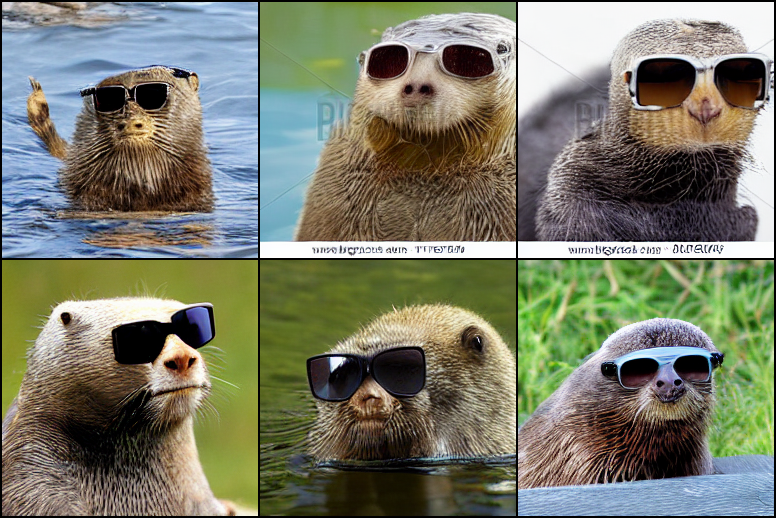

In [12]:
#@title Parameters
import argparse
Prompt = "An otter wearing sunglasses" #@param{type:"string"}
Steps = 50 #@param {type:"integer"}
ETA = 0 #@param{type:"integer"}
Iterations = 2 #@param{type:"integer"}
Width=256 #@param{type:"integer"}
Height=256 #@param{type:"integer"}
Samples_in_parallel=3 #@param{type:"integer"}
Diversity_scale=5.0 #@param {type:"number"}
PLMS_sampling=True #@param {type:"boolean"}

args = argparse.Namespace(
    prompt = Prompt, 
    outdir=f'{outputs_path}',
    ddim_steps = Steps,
    ddim_eta = ETA,
    n_iter = Iterations,
    W=Width,
    H=Height,
    n_samples=Samples_in_parallel,
    scale=Diversity_scale,
    plms=PLMS_sampling,
    nsfw_threshold=0.5
)
run(args)